# Training RNN (`HuggingFace`'s transformers) for natural language. 

1. [Language tasks: the BABI20 dataset](#sec1)  
2. [Training the transformer](#sec2)
3. [Validating the transformer](#sec3)

In [54]:
import matplotlib.pyplot as plt
import os
import pandas
import pickle
import random
import tensorflow as tf
import torchtext
import transformers

from IPython.display import display, HTML

print(torchtext.__version__)

0.4.0


<a id='sec1'></a>
## 1. Language tasks: the BABI20 dataset

We installed an old version (0.4.0) of `torchtext`. This module helps downloading and handling the Facebook's BABI training dataset. 
Here, we download the dataset from
`http://www.thespermwhale.com/jaseweston/babi/tasks_1-20_v1-2.tar.gz`

```
tasks_1-20_v1-2
├── en
├── en-10k
├── en-valid
├── en-valid-10k
├── hn
├── hn-10k
├── shuffled
└── shuffled-10k
```

The BABI dataset has 20 types of natural language tasks. We'll train a NN to solve language situations of a kind given by task #4.  We'll use folder `en-valid` contains 900 training task#4 examples and 100 validation examples. For finer tuning, one can use folder `en-valid-10k`, which contains 9000/100 training/validation examples. 

```
tasks_1-20_v1-2/en-valid/qa4_test.txt
tasks_1-20_v1-2/en-valid/qa4_train.txt
tasks_1-20_v1-2/en-valid/qa4_valid.txt
```

Each example in task #4 provides: 
  1. A `story`, which is composed of two sentences logically connected. 
  2. A `query`; predicting an answer to this question implies that the NN has an understanding of the `story`. 
  3. An `answer`, used to compared to our `predicted answer` and thus train the NN. 

 For illustration, below we show 10 examples, of the type task#4, randomly chosen from the training dataset `qa4_train.txt`. 

In [59]:

data_path = os.path.join(os.path.expanduser('~'), 'Downloads')
text_field = torchtext.datasets.babi.BABI20Field(50)
train_examples = torchtext.datasets.BABI20(data_path + '/tasks_1-20_v1-2/en-valid/qa4_train.txt', text_field) 
validation_examples = torchtext.datasets.BABI20(data_path + '/tasks_1-20_v1-2/en-valid/qa4_valid.txt', text_field) 
print(f'Folder en-valid contains {len(train_examples)} training examples.')
print(f'Folder en-valid contains {len(validation_examples)} validation examples.')

Folder en-valid contains 900 training examples.
Folder en-valid contains 100 validation examples.


In [61]:
stories_str = []
queries_str = []
answers_str = []
num_examples = len(train_examples)
selected_examples = random.sample(range(num_examples), 10)

for i in selected_examples:
    example = train_examples[i]

    aux_str = [' '.join(sentence) for sentence in example.story]

    story_str = '.\n '.join(aux_str) + '.'
    query_str = ' '.join(example.query) + '?'
    answer_str = example.answer[0] 

    stories_str.append(story_str)
    queries_str.append(query_str)
    answers_str.append(answer_str)


dict = {'Stories': stories_str,
        'Queries': queries_str,
        'Answers': answers_str,
        }

pandas.set_option('display.colheader_justify', 'center')
df = pandas.DataFrame(dict)
display(HTML(df.to_html().replace("\\n", "<br>") ))

,Stories,Queries,Answers
0,The bathroom is west of the garden. The bedroom is west of the bathroom.,What is the garden east of?,bathroom
1,The garden is east of the hallway. The office is west of the hallway.,What is the hallway east of?,office
2,The bathroom is east of the office. The office is east of the kitchen.,What is the kitchen west of?,office
3,The garden is west of the bedroom. The office is west of the garden.,What is west of the bedroom?,garden
4,The garden is north of the kitchen. The hallway is north of the garden.,What is the kitchen south of?,garden
5,The garden is east of the bedroom. The bathroom is east of the garden.,What is the bedroom west of?,garden
6,The office is north of the hallway. The garden is north of the office.,What is the office south of?,garden
7,The office is north of the bedroom. The bedroom is north of the kitchen.,What is north of the kitchen?,bedroom
8,The office is east of the kitchen. The bathroom is east of the office.,What is the kitchen west of?,office
9,The bathroom is south of the bedroom. The bedroom is south of the office.,What is south of the bedroom?,bathroom


<a id='sec2'></a>
## 2. Training the transformer

Number of samples per batches 16
Number of batches 570
Number of batches per epoch 57


Text(0.5, 0, 'Epoch number')

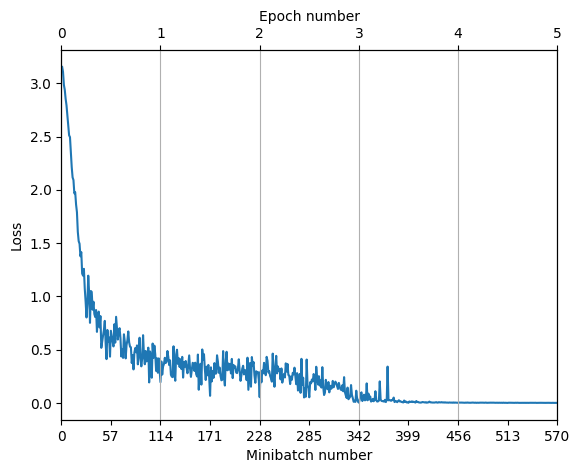

In [46]:

hyperparams_filename = "../models/01_27_24_audrygtw.hparams"
model_filename = "../models/01_27_24_audrygtw.keras"

hyperparams_filename = "../models/01_27_24_pgzdxpvv.hparams"
model_filename = "../models/01_27_24_pgzdxpvv.keras"

model_dirname = "../models/01_27_24_nhqfclsx"

with open(hyperparams_filename, 'rb') as f:
    hyperparams = pickle.load(f)
    
history = hyperparams['history']
batch_size = hyperparams['batch_size']
num_epochs = hyperparams['num_epochs']
losses = [tensor.numpy() for tensor in history]
num_batches = len(losses)
num_batches_per_epoch = int(num_batches / num_epochs)
print(f'Number of samples per batches {batch_size}')
print(f'Number of batches {num_batches}')
print(f'Number of batches per epoch {num_batches_per_epoch}')


fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.plot(range(1, num_batches+1), losses)
ax1.set_xlim([0, num_batches])
new_tick_locations = list(range(0, num_batches+1, num_batches_per_epoch))
ax1.set_xticks(new_tick_locations)
ax2 = ax1.twiny()

ax2.set_xticks(b)
ax2.grid(axis='x')

ax1.set_ylabel('Loss')
ax1.set_xlabel('Minibatch number')
ax2.set_xlabel('Epoch number')

<a id='sec3'></a>
## 3. Validating the transformer

In [44]:
tokenizer = transformers.AutoTokenizer.from_pretrained("distilbert-base-uncased")
loaded_model = transformers.TFDistilBertForQuestionAnswering.from_pretrained(model_dirname)
#loaded_model = TFDistilBertForQuestionAnswering.from_pretrained("distilbert-base-uncased")

data_path = os.path.join(os.path.expanduser('~'), '.torch', 'datasets', 'babi')
text_field = torchtext.datasets.babi.BABI20Field(50)
val_examples = torchtext.datasets.BABI20(data_path + '/tasks_1-20_v1-2/en-valid/qa4_valid.txt', text_field) 

stories_str = []
queries_str = []
answers_str = []
predicted_answers_str = []
for i,example in enumerate(val_examples):
    if i>50:
        break
    #story, query, answer = '\n'.join(' '.join(s) for s in example.story), ' '.join(example.query), ' '.join(example.answer)
    aux_str = [' '.join(sentence) for sentence in example.story]

    story_str = '. '.join(aux_str) + '.'
    story_str2 = '.\n '.join(aux_str) + '.'
    query_str = ' '.join(example.query) + '?'
    answer_str = example.answer[0] 

    stories_str.append(story_str2)
    queries_str.append(query_str)
    answers_str.append(answer_str)

    #print("story:", story_str)
    #print("query:", query_str)
    #print("answer:", answer_str)

    input_dict = tokenizer(story_str, query_str, return_tensors='tf')
    outputs = loaded_model(input_dict)
    start_logits = outputs[0]
    end_logits = outputs[1]
    
    story_tokens = tokenizer.convert_ids_to_tokens(input_dict["input_ids"].numpy()[0])
    predicted_answer = ' '.join(story_tokens[tf.math.argmax(start_logits, 1)[0] : tf.math.argmax(end_logits, 1)[0]+1])
    #print("predicted answer:", answer)
    predicted_answers_str.append(predicted_answer)

dict = {'Stories': stories_str,
        'Queries': query_str,
        'Answers': answers_str,
        'Predicted answers': predicted_answers_str
        }

pandas.set_option('display.colheader_justify', 'center')
df = pandas.DataFrame(dict)
display(HTML(df.to_html().replace("\\n", "<br>") ))

Some layers from the model checkpoint at ../models/01_27_24_nhqfclsx were not used when initializing TFDistilBertForQuestionAnswering: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForQuestionAnswering were not initialized from the model checkpoint at ../models/01_27_24_nhqfclsx and are newly initialized: ['dropout_599']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


,Stories,Queries,Answers,Predicted answers
0,The kitchen is west of the garden. The hallway is west of the kitchen.,What is the hallway east of?,kitchen,kitchen
1,The bathroom is south of the bedroom. The kitchen is north of the bedroom.,What is the hallway east of?,kitchen,kitchen
2,The bedroom is south of the kitchen. The kitchen is south of the hallway.,What is the hallway east of?,bedroom,bedroom
3,The hallway is west of the bedroom. The hallway is east of the garden.,What is the hallway east of?,hallway,hallway
4,The kitchen is south of the bedroom. The garden is north of the bedroom.,What is the hallway east of?,kitchen,kitchen
5,The hallway is west of the office. The kitchen is east of the office.,What is the hallway east of?,hallway,hallway
6,The hallway is west of the bathroom. The bathroom is west of the bedroom.,What is the hallway east of?,hallway,hallway
7,The garden is west of the office. The bedroom is west of the garden.,What is the hallway east of?,garden,garden
8,The hallway is east of the bedroom. The garden is west of the bedroom.,What is the hallway east of?,hallway,hallway
9,The office is north of the garden. The office is south of the bathroom.,What is the hallway east of?,office,office
